# Семинар 4. Регуляризация. Подбор гипепараметров. Валидация.

## Регуляризация

Модель линейной регрессии:

$$a(X_1, ... , X_n) = w_0 + w_1 X_1 + ... + w_n X_n = x^T w$$

$$w = (w_0, w_1, ... , w_n)^T$$

$$x = (X_0, X_1, ... , X_n)^T, \text{где $X_0 = 1$ - фиктивный признак}$$

Обучение по выборке: 
- ${(x_1, y_1), (x_2, y_2), ... , (x_m, y_m)}, x_i \in \mathbb{R}^{n+1}$ 
Дает систему:

\begin{equation*}
 \begin{cases}
   x_1^Tw = y_1\\
   ... \\
   x_m^T w = y_m
 \end{cases}
 \Leftrightarrow Xw = y
\end{equation*}

$$L(w) = \|Xw - y \|_2^2 \rightarrow \min_w$$

$$\|Xw - y \|_2^2 = (Xw - y)^T(Xw - y) = w^T X^T X w - w^TX^Ty - y^TXw + y^Ty$$

$$\nabla \|Xw - y \|_2^2 = 2X^T Xw - 2X^T y = 0 \Rightarrow w = (X^TX)^{-1}X^T y$$
- Решение в матричной форме существует, если столбцы линейно независимые.

Один из способ борьбы с вырожденностью является **регуляризация**. Это метод добавления некоторых дополнительных ограничений к условию с целью решить некорректно поставленную задачу или предотвратить переобучение. Чаще всего эта информация имеет вид штрафа за сложность модели.

#### Интуиция

Представим, что в нашем распоряжении имеется модель линейной регрессии: $a(X_1, ... , X_n) = w_0 + w_1 X_1 + ... + w_n X_n$, а в обучающей выборке есть $2$ похожих объекта, которые различаются на $j-$ом признаке, тогда и ответы модели на них будут отличаться, как $\varepsilon_j w_j$; 
- $\rightarrow$ вместе с $\|Xw - y \|_2^2 \rightarrow \min_w$ хотим некоторым образом минимизировать веса $w$ модели.

### Ridge Regression. Регуляризация Тихонова.

$$L_2(w) = \| Xw - y \|_2^2 + \lambda \| w \|_2^2 \rightarrow \min$$

$$\nabla L_2(w) = 2X^T Xw - 2X^T y + 2 \lambda w = 0$$

$$w = (X^T X + \lambda I)^{-1} X^T y$$

- борется с вырожденностью матрицы
- при $\lambda = 0$ получаем классическое решение
- при $\lambda \rightarrow + \infty$ меньше затачиваемся под данные, больше регуляризируем

### LASSO Regression.

$$L_1(w) = \| Xw - y \|_2^2 + \lambda \| w \|_1 \rightarrow \min$$

- регуляризатор не является гладкой функцией, найти аналитическое решение не представляется возможным

Тут же отметим, что для аналитического решения все не так просто и в случае без регуляризации, и в случае регуляризации Тихонова. 

- Вычислительная сложность аналитического решения: $O(n^2 \cdot m + n^3)$, где $m$ — длина выборки, $n$ — число признаков у одного объекта.
- Матрица $X^TX$, хотя почти всегда обратима в разумных задачах машинного обучения, зачастую плохо обусловлена. Особенно если признаков много, между ними может появляться приближённая линейная зависимость, которую мы можем упустить на этапе формулировки задачи. Это делает полученное таким образом решение численно неустойчивым: малые возмущения $y$ могут приводить к катастрофическим изменениям $w$.

Сравним **скорость поиска решения** с помощью градиентного спуска и аналитического решения.

In [1]:
import numpy as np

M = 500000
N = 1999

X = np.random.randn(M, N)
X = np.hstack((X, np.ones((M, 1))))
w = np.random.randn(N+1)
y = X @ w

$$w = (X^TX)^{-1}X^T y$$

In [2]:
%%timeit

(np.linalg.inv(X.T @ X)@X.T@y)

1min 14s ± 7.74 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [3]:
w_analytical = np.linalg.inv(X.T @ X)@(X.T@y)

In [4]:
np.linalg.norm(w_analytical - w)

np.float64(4.273708277916715e-13)

In [5]:
def grad_desc(X, y, w_res, N, M, tolerance, alpha=0.5):
    # случайная инициализация
    w = np.random.randn(N+1)
    diff = tolerance
    count = 0
    while diff >= tolerance:
        err = X.dot(w) - y
        grad = 2 * X.T.dot(err) / M
        w -= alpha * grad
        diff = np.linalg.norm(w - w_res)
        count += 1
    return w

In [6]:
%%timeit

grad_desc(X, y, w, N, M, np.linalg.norm(w_analytical - w))

9.2 s ± 280 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


- Использование градиентного спуска позволяет найти решение задачи существенно быстрее.

Аналогично в случае **Ridge-регрессии** имеет смысл использовать градиентный спуск. Но что делать для решения **LASSO-регрессии**?

### Минутка оптимизации. 

#### Субдифференциальные исчисления.

**Опр 1.** Пусть дана функция $f: \mathbb{R}^d \rightarrow \mathbb{R}$ и точка $x_0 \in \mathbb{R}^d$. Точка $z \in \mathbb{R}^d$ называется субградиентом функции $f$ в точке $x_0$ , если для всех $x \in \mathbb{R}^d$ выполнено:
$$f(x) \ge f(x_0) + \langle z, x − x_0 \rangle$$

**Опр 2.** Множество всех субградиентов функции $f$ в точке $x_0$ называется субдифференциалом функции в точке $x_0$ , будем обозначать его $\partial f(x_0)$.

--------------------------------

**Пример.** Пусть $f: \mathbb{R} → \mathbb{R}$ функция $f(x) = |x|$. Тогда $\partial f(0) = [−1, 1]$.

*Доказательство.* Пусть $z\in [−1, 1]$. Тогда $zx \le |z||x| ≤ |x|$ для всех $x \in \mathbb{R}$, т. е., по определению, $z \in \partial f(0)$. В силу произвольности $z$, это означает, что $[−1, 1] ⊆ \partial f(0)$. Остается показать, что вложение, на самом деле, является равенством.

Предположим, чтобы прийти к противоречию, что найдется $z \in \partial f(0)$, такое, что $|z| > 1$. Тогда, по определению субградиента, $|x| \ge zx$ для всех $x \in \mathbb{R}$. Полагая $x = z$, получаем $|z| \ge |z|^2$, что невозможно.

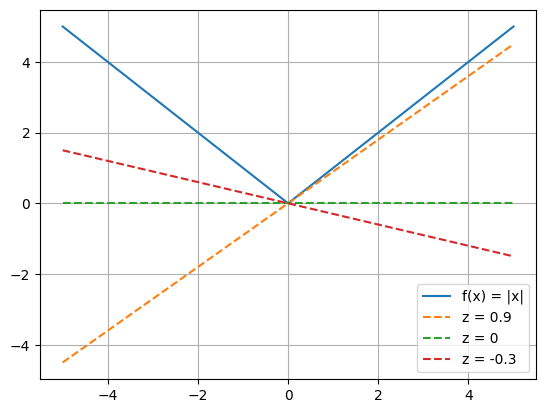

In [7]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-5, 5, 1000)
plt.plot(x, np.abs(x), label="f(x) = |x|")
plt.plot(x, 0.9*x, "--", label="z = 0.9")
plt.plot(x, 0*x, "--", label="z = 0")
plt.plot(x, -0.3*x, "--", label="z = -0.3")
plt.grid()
plt.legend()

**Утв. 1.** (Субдифференциал дифференцируемой функции) Пусть $f: \mathbb{R}^d \rightarrow \mathbb{R}$, $f$ — дифференцируема в точке $x_0 \in \mathbb{R}^d$. Тогда либо $\partial f(x_0) = \emptyset$, либо $\partial f(x_0) = \{ \nabla f(x_0) \}$. Если $f$ — выпукла, то $f$ — дифференцируема в точке $x_0$ тогда и только тогда, когда $\partial f(x_0) = \{ \nabla f(x_0) \}$

**Утв. 2.** (Критерий минимума) Пусть $f: \mathbb{R}^d \rightarrow \mathbb{R}$, $x_0 \in \mathbb{R}^d$ — минимум функции тогда и
только тогда, когда $0 \in \partial f(x_0)$.

Понятие субдифференциала позволяет использовать метод **субградиентного спуска** для выпуклых, но негладких задач оптимизации:

$$x_{k+1} = x_k - \alpha_k g^k(x_k)$$

где $g^k \in \partial f(x_k)$ - любой из субградиентов функции $f$ в точке $x_k$.

***В самом общем случае*** это(и его производные) единственный метод, который можно использовать для решения негладких выпуклых задач. Однако он имеет ***низкую скорость сходимости***. 

#### Проксимальный метод.

Рассмотрим обратную схему Эйлера:

$$\frac{x_{k+1} - x_k}{\alpha} = - \nabla f(x_{\textcolor{red}{k+1}})$$

$$\frac{x_{k+1} - x_k}{\alpha} + \nabla f(x_{k+1}) = 0$$

$$\nabla \left [ \dfrac{1}{2 \alpha } \| x - x_k \|_2^2 + f(x) \right ] \Bigg |_{x = x_{k+1}} = 0$$

Если функция $f(x)$ выпуклая, то $f(x) + \dfrac{1}{2 \alpha } \| x - x_k \|_2^2$ тоже выпуклая, и её стационарная точка будет точкой минимума. Стало быть, $x_{k+1}$ можно высчитывать по формуле

$$x_{k+1} = \arg \min_u \left \{ f(u) + \dfrac{1}{2 \alpha } \| u - x_k \|^2 \right \}$$

**Опр. 3.** Определим **прокс-оператор** следующим образом:

$$prox_{f}(x_k) = \arg \min_u \left \{ f(u)  + \dfrac{1}{2 \alpha_k} \| u - x_k \|^2 \right \}$$

Итеративный процесс $x_{k+1}=prox_{f}(x_k)$ называется **методом проксимальной минимизации**.

Использование этого метода позволяет эффективно решать задачи композитной оптимизации специального вида:

$$f(x) + r(x) \rightarrow \min$$

где $f(x)$ - гладкая функция, а $r(x)$ - *prox-friendly* функция, для которой прокс-оператор считается аналитически.

Воспользуемся следующим алгоритмом: по $f(x)$ будем совершать шаг градиентного спуска, а по $r(x)$ шаг проксимального метода:

$$x_{k+1} = prox_{\alpha_k r} (x_k - \alpha_k \nabla f(x_k))$$

Эта процедура определяет так называемый **проксимальный градиентный метод (Proximal Gradient Method, PGM)**.

- К чему была вся эта затянувшаяся "минутка оптимизации"?
    - Есть задача LASSO регрессии, которую мы не можем решить аналитически
    - Градиентный спуск неприменим
    - Метод субградиента медленный
    - Вероятно у нас получится посчитать прокс-оператор для недифференцируемой функции $\| w \|_1$

### [ISTA](https://www.ceremade.dauphine.fr/~carlier/FISTA)

$$L_1(w) = f(w) + r(w) = \| Xw - y \|_2^2 + \lambda \| w \|_1 \rightarrow \min$$

Найдем проксимальный оператор для $r(w) = \| w \|_1$ $l1$-нормы.

$$prox_{\alpha \| \cdot \|_1} = \arg \min_u \left \{ \| u \|_1 + \dfrac{1}{2 \alpha} \| u - x \|_2^2 \right \} = \arg \min_u \left \{ \sum_i |u_i|  + \dfrac{(u_i - x_i)^2}{2 \alpha} \right \}$$

Заметим, что компоненты не влияют друг на друга, а стало быть мы можем проводить покомпонентную минимизацию (для краткости опустим индексацию):

$$g(u) = |u| + \dfrac{(u - x)^2}{2 \alpha} \rightarrow \arg \min_u$$

- $u > 0$:
  - $g(u) = u + \dfrac{(u - x)^2}{2 \alpha}$
    - $\nabla g(u) = 1 + \dfrac{u-x}{\alpha} = 0 \rightarrow u = x - \alpha, x > \alpha$
   
- $u < 0$:
  - $g(u) = - u + \dfrac{(u - x)^2}{2 \alpha}$
    - $\nabla g(u) = -1 + \dfrac{u-x}{\alpha} = 0 \rightarrow u = x + \alpha, x < - \alpha$
   
- $u = 0$:
  - $0 \in \partial g(0) = [-1; 1] - \dfrac{x}{\alpha} \rightarrow 0 \in [-\alpha; \alpha ] - x$
    - $- \alpha \le x \le \alpha $
   
Таким образом,

\begin{equation*}
prox_{\alpha \| \cdot \|_1 }(x)_i = 
 \begin{cases}
   x_i - \alpha, \ \ \ \ x_i > \alpha \\
   0, \ \ \ \ \ -\alpha \le x_i \le \alpha \\
   x_i + \alpha, \ \ \ \ x_i < -\alpha
 \end{cases}
\end{equation*}

Text(0.5, 1.0, '$prox_{\\alpha \\| \\cdot \\|_1}$')

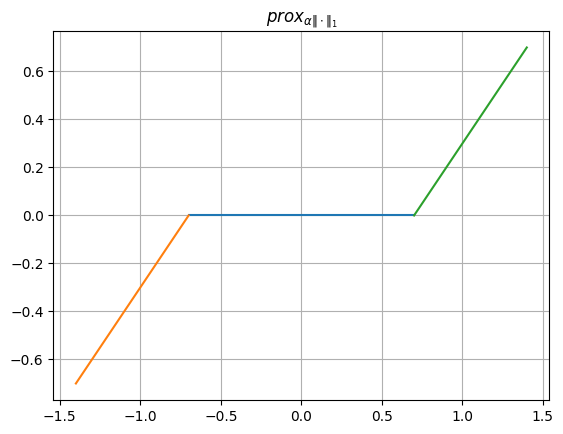

In [8]:
import numpy as np
import matplotlib.pyplot as plt

alpha = 0.7

x_left = np.linspace(-2*alpha, -alpha, 1000)
x_right = np.linspace(alpha, 2*alpha, 1000)
x_center = np.linspace(-alpha, alpha, 1000)
plt.plot(x_center, 0*x_center)
plt.plot(x_left, alpha+x_left)
plt.plot(x_right, x_right-alpha)
plt.grid()
plt.title(r"$prox_{\alpha \| \cdot \|_1}$")

Тогда шаг $ISTA$ будет иметь следюущий вид:
$$w_{k+1} = prox_{\lambda \alpha_k \| \cdot \|_1} (w_k - \alpha_k \nabla f(w_k)) = prox_{\lambda \alpha_k \| \cdot \|_1} (w_k - \alpha_k X^T(Xw_k - y))$$

Cуществует также ускоренная версия ISTA - [**FISTA**](https://www.ceremade.dauphine.fr/~carlier/FISTA) (Fast ISTA).

### Регуляризация, как способ отбора признаков.

In [9]:
np.random.seed(10)

X = np.random.rand(1000, 6)

X[:,1] = X[:,0]
X[:,2] = X[:,3]

X[:,0] = 1 * X[:,0]
X[:,1] = 2 * X[:,1]
X[:,2] = 1 * X[:,2]
X[:,3] = 3 * X[:,3]
X[:,4] = 1 * X[:,4]
X[:,5] = 2 * X[:,5]

y = 1.5 * X[:, 0] + 2 * X[:, 2] + 0.5 * np.random.rand(1000)

In [10]:
from sklearn.linear_model import Lasso, Ridge

models_l1 = []
models_l2 = []
alphas_l1 = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1]
alphas_l2 = [1e-3, 1e-1, 1e1, 1e3, 1e4, 1e5, 1e6]

for alpha1, alpha2 in zip(alphas_l1, alphas_l2):
    models_l1.append(Lasso(alpha=alpha1, random_state=0).fit(X, y))
    models_l2.append(Ridge(alpha=alpha2, random_state=0).fit(X, y))

/home/dmitry/any/study/ISP/ISP_ML1_2025_st/seminars/seminar4/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.280e-01, tolerance: 5.783e-02
  model = cd_fast.enet_coordinate_descent(


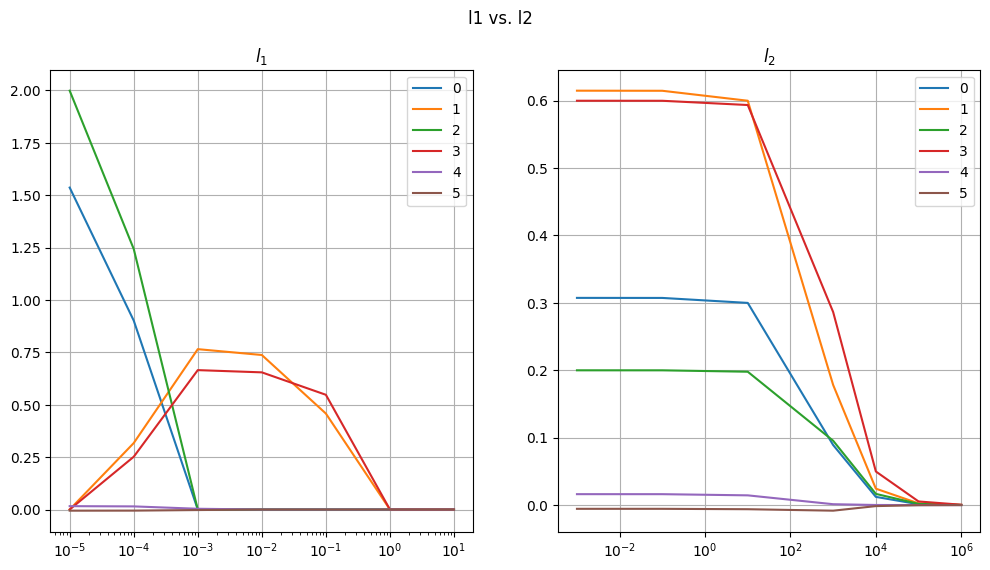

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('l1 vs. l2')

ax1.set_title("$l_1$")
ax1.set_xscale("log")
ax1.plot(alphas_l1, np.array([model.coef_ for model in models_l1]), label=np.arange(6))
ax1.legend()
ax1.grid()

ax2.set_title("$l_2$")
ax2.set_xscale("log")
ax2.plot(alphas_l2, np.array([model.coef_ for model in models_l2]), label=np.arange(6))
ax2.legend()
ax2.grid()

Основное различие LASSO и Ridge регрессий заключается в том, что первая может приводить к обращению некоторых независимых переменных в ноль, тогда как вторая уменьшает их до значений, близких к нулю.

Продублируем наглядный пример из статьи о вариациях регрессии. Рассмотрим для простоты двумерное пространство независимых переменных. В случае LASSO регрессии органичение на коэффициенты представляет собой ромб $(|w_1|+|w_2|\le t)$, в случае гребневой регрессии — круг $(w_1^2+w_2^2 \le t^2)$. Необходимо минимизировать функцию ошибки, но при этом соблюсти ограничения на коэффициенты. С геометрической точки зрения задача состоит в том, чтобы найти точку касания линии, отражающей функцию ошибки с фигурой, отражающей ограничения на $w$. Из Рис. ниже интуитивно понятно, что в случае LASSO регрессии эта точка с большой вероятностью будет находиться на углах ромба, то есть лежать на оси, тогда как в случае Ridge регрессии такое происходит очень редко. Если точка пересечения лежит на оси, один из коэффициентов будет равен нулю, а значит, значение соответствующей независимой переменной не будет учитываться. 

<div style="text-align:center">,
<img src="./src/Ridge_and_Lasso.png" width="650px">,
</div>

### ElasticNet = Ridge + LASSO

Еще один вид регуляризации, который объединяет в себе, как $L_1$, так и $L_2$ нормы.

$$L_e(w) = \| Xw - y \|_2^2 + \lambda_1 \| w \|_1 + \lambda_2 \| w \|_2^2 \rightarrow \min$$

Промежуточные итоги:
  - Ridge
    - применяется в случае мультиколлинеарности через добавление $L_2$-регуляризации к функции потерь во время обучения и сильнее всего занижает веса для признаков с высокой корреляцией: их значения будут приближаться к нулю, но никогда его не достигнут.
    - лучше всего применять гребневую регрессию после стандартизации признаков.
  - LASSO
    - используется для отбора признаков через добавление $L_1$-регуляризации к функции потерь во время обучения. Проще говоря, лассо-регрессия стремится уменьшить число параметров модели путем зануления весов для неинформативных и избыточных признаков, что на выходе даст разреженную модель (с небольшим числом ненулевых весов признаков).
  - ElasticNet
    - представляет собой комбинацию $L_1$ и $L_2$-регуляризаций, что может принести особую пользу в ситуациях, когда в данных необходимо одновременно выполнять отбор признаков и бороться с мультиколлинеарностью.

## Подбор гиперпараметров.

### Параметры регуляризации в Scikit-Learn.

В Scikit-Learn есть реализации всех рассмотренных версий линейной регрессии (и даже больше):
 - [Линейная регрессия без регуляризации](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
     - $\|y - Xw\|^2_2$
 - [Ridge регрессия](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)
     - $\|y - Xw\|^2_2 + \alpha \cdot \|w\|^2_2$
 - [LASSO регрессия](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso)
     - $\frac{1}{2m} \|y - Xw\|^2_2 + \alpha  \|w\|_1$
 - [ElasticNet регрессия](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet)
     -  $\frac{1}{2m} \|y - Xw\|^2_2 + \alpha \cdot l_{1_{ratio}} \cdot \|w\|_1 + \frac{\alpha}{2} \cdot (1 - l_{1_{ratio}}) \cdot \|w\|^2_2$
  
Для Ridge, LASSO и ElasticNet есть также реализации, ищущие оптимальное значение параметров регуляризации из заданного множества:
  - [RidgeCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html)
  - [LassoCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html)
  - [ElasticNetCV]([https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html])

### Простейшие стратегии подбора гиперпараметров.

#### Поиск по сетке. [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
Самым наивным способом поиска оптимального набора гиперпараметров является поиск по сетке. Метод выполняет полный перебор по изначально заданному подмножеству гиперпараметров выбранного алгоритма. Так как пространство поиска гиперпараметров выбранной модели машинного обучения может быть непрерывным и неограниченным, ML-разработчик сам должен установить границы и провести дискретизацию значений. Качество алгоритма поиска обычно определяется с помощью перекрестной проверки или отложенного набора данных. В результате своей работы алгоритм **поиска по сетке** выдаёт модель с гиперпараметрами, на которых был достигнут наилучший результат в процессе проверки.

Основным недостатком данного метода является *проклятие размерности* -- проблема экспоненциального роста необходимых экспериментальных данных в зависимости от роста размерности пространства. Однако обычно метод довольно легко поддается распараллеливанию, так как зачастую гиперпараметры не зависят друг от друга.  


#### Случайный поиск. [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
Основной идей случайного поиска является независимое сэмлирование из заранее определенного подмножества гиперпараметров до тех пор, пока не будет исчерпан заранее определенный бюджет, например, максимальное количество итераций. В отличие от предыдущего метода от разработчика не требуется проводить дискретизацию непрерывных значений, нужно лишь ограничить пространство поиска. Так же, как и  *поиск по сетке*, *случайный поиск* поддерживает параллельную работу, так как вычисления могут выполняться независимо, а также позволяет использовать априорные знания об оптимизируемых параметрах путем указания распределения на них. *Случайный поиск* превосходит *поиск по сетке* в случае, если на качество модели оказывает влияние лишь малое количество параметров.

<div style="text-align:center">,
<img src="./src/grid_vs_random_search.png" width="650px">,
</div>

График функция $g(x)$ изображен зеленым цветом сверху квадрата, а график функции $h(y)$ представлен на левой боковой части квадрата. В случае использования поиска по сетке, из $9$ измерений только $3$  протестируют функцию $g(x)$ в разных точках. При использовании случайного поиска все $9$ измерений эффективно исследуют $g(x)$ в $9$ разных точках. Такое поведение метода *поиска по сетке* в сравнении с методом *случайного поиска* является скорее правилом, чем исключением, в многомерной гиперпараметрической оптимизации.

[**Примеры использования.**](https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-optimization)

**Другие библиотеки**: [Optuna](https://optuna.org/), [scikit-optimize](https://scikit-optimize.github.io/stable/index.html), [hyperopt](http://hyperopt.github.io/hyperopt/).

### Ссылки
- [Методы Оптимизации, ВМК МГУ, Субдифференциалы](http://www.machinelearning.ru/wiki/images/e/e5/MOMO18_Seminar10.pdf)
- [Проксимальный градиентный метод. Проксимальный оператор и его свойства. МФТИ 2024](https://youtu.be/K014nmjb-d8?si=deGPhQUivm3Ulk4q)
- [Проксимальные методы](https://education.yandex.ru/handbook/ml/article/proksimalnye-metody)
- [Методы оптимизации в машинном и глубоком обучении. От простого к сложному](https://habr.com/ru/articles/813221/)
- [Полезный сайт по оптимизации](https://fmin.xyz/)
- [FISTA](https://www.ceremade.dauphine.fr/~carlier/FISTA)
- [Линейные модели](https://education.yandex.ru/handbook/ml/article/linear-models)
- [Регуляризация](https://neerc.ifmo.ru/wiki/index.php?title=%D0%A0%D0%B5%D0%B3%D1%83%D0%BB%D1%8F%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F)
- [Линейная регрессия. Основная идея, модификации и реализация с нуля на Python](https://habr.com/ru/articles/804135/)
- [Подбор гиперпараметров](https://education.yandex.ru/handbook/ml/article/podbor-giperparametrov)